<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "Exc"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level2-MajorCellType/Exc/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


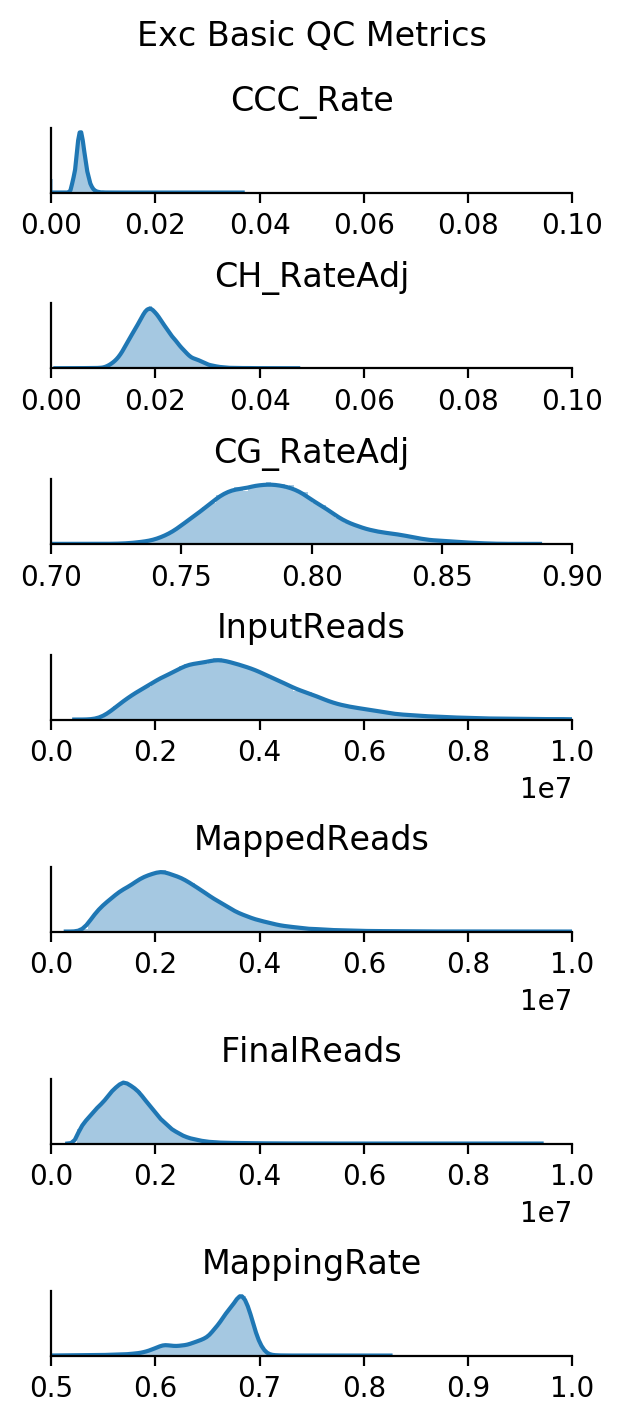

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

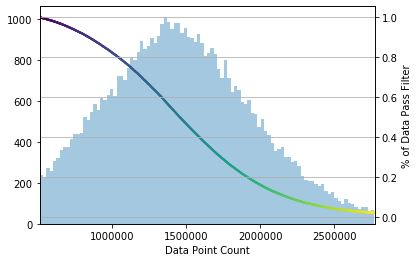

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 53395/53395 (100.0%)
CG_RateAdj passed 53395/53395 (100.0%)
CH_RateAdj passed 53395/53395 (100.0%)
FinalReads passed 53395/53395 (100.0%)
MappingRate passed 53395/53395 (100.0%)
Overall passed 53395/53395 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 956
171207 944
171212 232
171213 913
171214 82
171219 86
180104 1036
180109 171
180110 25
180111 4
180119 1037
180122 964
180123 1166
180129 1205
180130 1025
180205 988
180206 1053
180208 479
180212 474
180213 1105
180220 861
180222 652
180226 1055
180227 816
180305 792
180306 1055
180312 1063
180313 390
180319 237
180320 947
180326 894
180329 801
180402 813
180403 1028
180405 291
180409 847
180410 718
180412 847
180416 1039
180417 810
180419 758
180423 975
180424 729
180426 1000
180430 949
180501 857
180514 683
180529 924
180605 968
180612 1045
180724 1
180806 3
180911 5
180917 157
180925 24
181002 893
181008 994
181009 984
181022 1044
181023 1052
181204 88
181206 45
181210 886
181218 74
181220 168
190108 1103
190117 1092
190122 942
190124 899
190131 969
190205 2051
190212 8
190214 99
190219 5
190305 103
190307 886
190625 12
190627 18
190716 1


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 6586 1715.1%
ad002 6756 1759.4%
ad004 6687 1741.4%
ad006 6688 1741.7%
ad007 6652 1732.3%
ad008 6731 1752.9%
ad010 6626 1725.5%
ad012 6669 1736.7%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,MappingRate,Pos96,Plate,Col96,Row96,Col384,Row384,FACS_Date,Slice,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
10E_M_1278,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.006996,0.757424,0.755715,0.031042,0.024215,2314675.0,6686084,4610594.0,10E,...,0.689581,F4,CEMBA190625-10E-4,3,5,7,11,190625,10,True
10E_M_135,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.007693,0.806861,0.805364,0.035217,0.027738,1654479.0,4242320,2762984.0,10E,...,0.651291,B3,CEMBA190625-10E-1,2,1,5,3,190625,10,True
10E_M_1507,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.006342,0.802387,0.801126,0.031122,0.024939,1991029.0,5483024,3528895.0,10E,...,0.643604,A1,CEMBA190627-10E-1,0,0,0,0,190627,10,True
10E_M_1614,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.007064,0.809248,0.807891,0.031460,0.024570,2190672.0,6467888,4259737.0,10E,...,0.658598,B10,CEMBA190627-10E-2,9,1,19,2,190627,10,True
10E_M_1737,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.006698,0.800241,0.798894,0.030182,0.023643,630412.0,2183164,1284613.0,10E,...,0.588418,C3,CEMBA190627-10E-2,2,2,5,4,190627,10,True
10E_M_1882,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.007010,0.816145,0.814847,0.032605,0.025775,2399546.0,7437820,4948836.0,10E,...,0.665361,E1,CEMBA190627-10E-2,0,4,0,8,190627,10,True
10E_M_1923,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.006946,0.777097,0.775538,0.031242,0.024465,1617403.0,5071650,3011348.0,10E,...,0.593761,E3,CEMBA190627-10E-2,2,4,5,9,190627,10,True
10E_M_1959,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.007086,0.798691,0.797255,0.032304,0.025397,1689099.0,5089912,3262583.0,10E,...,0.640990,E8,CEMBA190627-10E-2,7,4,14,9,190627,10,True
10E_M_1982,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.006872,0.805080,0.803732,0.031300,0.024597,2014135.0,5741712,3754082.0,10E,...,0.653826,F10,CEMBA190627-10E-2,9,5,18,10,190627,10,True
